In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import tqdm
from sklearn.decomposition import PCA

import configs.deconv, configs.unet
from unet import UNet
from unet_deconv import UNetDeconv



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [25]:
def loss(output, target):
    return torch.nn.functional.mse_loss(output, target)

def so3_equivariance_error(model, data, rotated_data):
    """
    Calculate the SO(3) equivariance error for the model.

    Parameters:
    model: torch.nn.Module
        The model to evaluate.
    data: torch.Tensor
        The input data (original).
    rotated_data: torch.Tensor
        The input data rotated externally (e.g., by 45 degrees).

    Returns:
    float: The SO(3) equivariance error.
    """
    model.eval()
    errors = []

    with torch.no_grad():
        # Pass both original and rotated data through the model
        original_output = model(data)
        rotated_output = model(rotated_data)

        # Calculate the equivariance error
        error = torch.norm(rotated_output - original_output) / torch.norm(original_output)
        errors.append(error.item())

    return np.mean(errors)


def train_loop(dataloader, model, loss_fn, optimizer, num_epochs=10):
    pbar = tqdm.tqdm(range(num_epochs), desc='Loss = N/A | Epochs')
    loss_history = []
    for _ in pbar:
        total_loss = 0
        for data in dataloader:
            pred = model(data)
            loss = loss_fn(pred, data)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        pbar.set_description(f'Loss = {avg_loss:.6f} | Epochs')
       # pbar.set_description(f'Loss = {total_loss:.6f} | Epochs')
    return loss_history


def evaluate_model(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in dataloader:
            pred = model(data)
            loss = loss_fn(pred, data)
            total_loss += loss.item()
    return total_loss / len(dataloader)

def analyze_latent_space(model, dataloader):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for data in dataloader:
            latent = model.down(data)[-1]  # Extract bottleneck features
            latent_vectors.append(latent.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(latent_vectors.reshape(latent_vectors.shape[0], -1))

    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)
    plt.title("PCA of Latent Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

In [18]:
# Viewer function for visualization
def viewer(image, x, y, z):
    plt.gray()
    fig, ax = plt.subplots(1, 3)
    fig.tight_layout()

    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].imshow(image[:, :, z])
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('z')
    ax[1].imshow(np.flip(image[x, :, :].transpose()))
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('z')
    ax[2].imshow(image[:, y, :])
    ax[1].set_title(f"Slices at {x}, {y}, {z}")
    plt.show()


In [19]:
def plot_loss(loss_history, title):
    plt.figure()
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load data
stripes_x = np.load("stripes_x_32x32.npy")
checkerboard_x = np.load("checkerboard_32x32.npy")
rot_stripes_x = np.load("XY_45_rotated_stripes_x_32x32.npy")

striped_dataset = stripes_x.astype(np.float32)
striped_dataset = np.expand_dims(striped_dataset, axis=0)
striped_dataset = np.expand_dims(striped_dataset, axis=0)
striped_dataset = torch.from_numpy(striped_dataset).to("cuda")
striped_dataloader = DataLoader(striped_dataset, batch_size=1, shuffle=True)

rot_striped_dataset = rot_stripes_x.astype(np.float32)
rot_striped_dataset = np.expand_dims(rot_striped_dataset, axis=0)
rot_striped_dataset = np.expand_dims(rot_striped_dataset, axis=0)
rot_striped_dataset = torch.from_numpy(rot_striped_dataset).to("cuda")
rot_striped_dataloader = DataLoader(rot_striped_dataset, batch_size=1, shuffle=True)

checkerboard_dataset = checkerboard_x.astype(np.float32)
checkerboard_dataset = np.expand_dims(checkerboard_dataset, axis=0)
checkerboard_dataset = np.expand_dims(checkerboard_dataset, axis=0)
checkerboard_dataset = torch.from_numpy(checkerboard_dataset).to("cuda")
checkerboard_dataloader = DataLoader(checkerboard_dataset, batch_size=1, shuffle=True)





In [21]:
# Initialize models
unet_model_stripes = UNet(**configs.unet.get_config().unet).to(device)
unet_model_checkerboard = UNet(**configs.unet.get_config().unet).to(device)
deconv_model_stripes = UNetDeconv(**configs.deconv.get_config().unet).to(device)
deconv_model_checkerboard = UNetDeconv(**configs.deconv.get_config().unet).to(device)


Training Vanilla UNet on striped patterns...


Loss = N/A | Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Loss = 0.269244 | Epochs: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


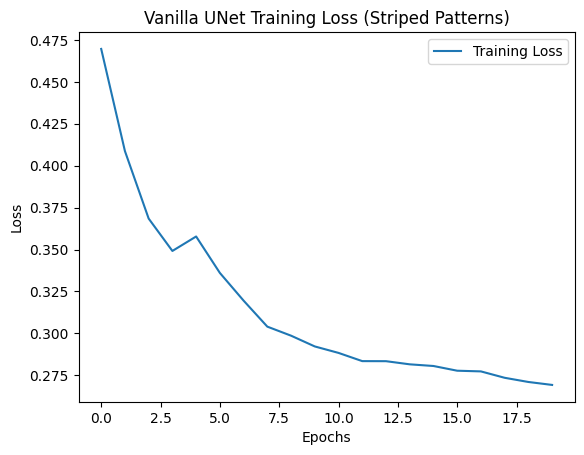

Training Vanilla UNet on checkerboard patterns...


Loss = 0.959872 | Epochs: 100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


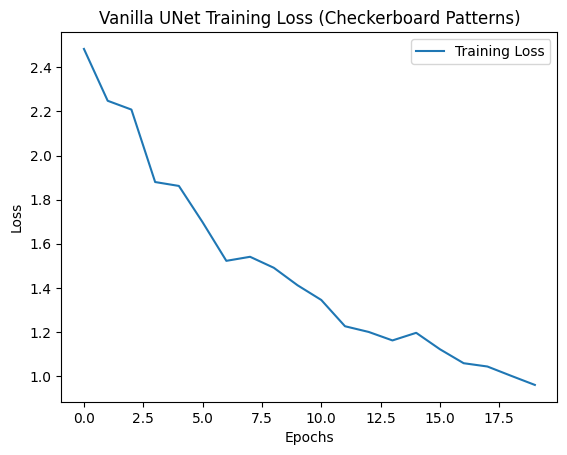

Training DeconvUNet on striped patterns...


Loss = 0.253043 | Epochs: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


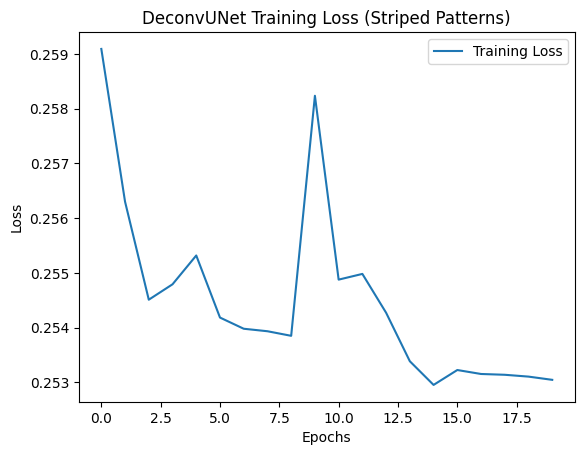

Training DeconvUNet on checkerboard patterns...


Loss = 0.251551 | Epochs: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


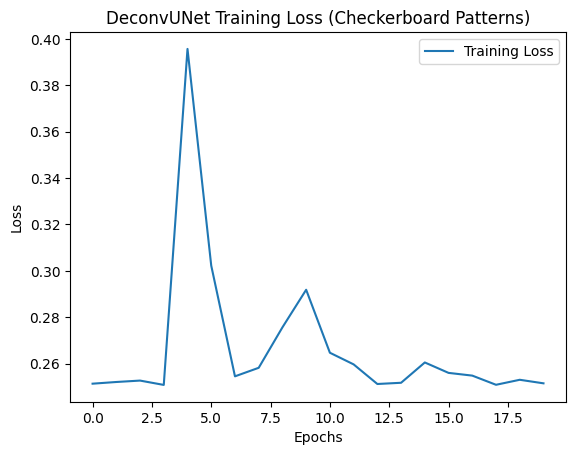

In [22]:
# Train Vanilla UNet on striped patterns
print("Training Vanilla UNet on striped patterns...")
unet_stripes_loss_history = train_loop(striped_dataloader, unet_model_stripes, loss, torch.optim.Adam(unet_model_stripes.parameters()), num_epochs=20)
plot_loss(unet_stripes_loss_history, "Vanilla UNet Training Loss (Striped Patterns)")

# Train Vanilla UNet on checkerboard patterns
print("Training Vanilla UNet on checkerboard patterns...")
unet_checkerboard_loss_history = train_loop(checkerboard_dataloader, unet_model_checkerboard, loss, torch.optim.Adam(unet_model_checkerboard.parameters()), num_epochs=20)
plot_loss(unet_checkerboard_loss_history, "Vanilla UNet Training Loss (Checkerboard Patterns)")

# Train DeconvUNet on striped patterns
print("Training DeconvUNet on striped patterns...")
deconv_stripes_loss_history = train_loop(striped_dataloader, deconv_model_stripes, loss, torch.optim.Adam(deconv_model_stripes.parameters()), num_epochs=20)
plot_loss(deconv_stripes_loss_history, "DeconvUNet Training Loss (Striped Patterns)")

# Train DeconvUNet on checkerboard patterns
print("Training DeconvUNet on checkerboard patterns...")
deconv_checkerboard_loss_history = train_loop(checkerboard_dataloader, deconv_model_checkerboard, loss, torch.optim.Adam(deconv_model_checkerboard.parameters()), num_epochs=20)
plot_loss(deconv_checkerboard_loss_history, "DeconvUNet Training Loss (Checkerboard Patterns)")


Evaluating models...


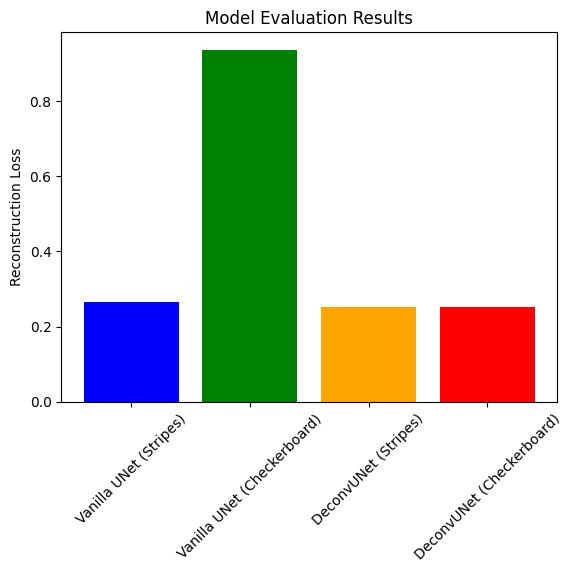

In [23]:
# Evaluate models
print("Evaluating models...")
results = {
    "Vanilla UNet (Stripes)": evaluate_model(striped_dataloader, unet_model_stripes, loss),
    "Vanilla UNet (Checkerboard)": evaluate_model(checkerboard_dataloader, unet_model_checkerboard, loss),
    "DeconvUNet (Stripes)": evaluate_model(striped_dataloader, deconv_model_stripes, loss),
    "DeconvUNet (Checkerboard)": evaluate_model(checkerboard_dataloader, deconv_model_checkerboard, loss),
}

# Visualize evaluation results
plt.bar(results.keys(), results.values(), color=["blue", "green", "orange", "red"])
plt.ylabel("Reconstruction Loss")
plt.title("Model Evaluation Results")
plt.xticks(rotation=45)
plt.show()



In [28]:
# SO(3) Equivariance Error
print("Calculating SO(3) equivariance error using rotated stripes...")
equiv_error_unet = so3_equivariance_error(unet_model_stripes, striped_dataset[0:1], rot_striped_dataset[0:1])
print(f"UNet SO(3) Equivariance Error: {equiv_error_unet}")

equiv_error_deconv = so3_equivariance_error(deconv_model_stripes, striped_dataset[0:1], rot_striped_dataset[0:1])
print(f"UNet SO(3) Equivariance Error: {equiv_error_deconv}")



Calculating SO(3) equivariance error using rotated stripes...
UNet SO(3) Equivariance Error: 0.7750845551490784
UNet SO(3) Equivariance Error: 0.5184000134468079


Analyzing latent space for UNet...


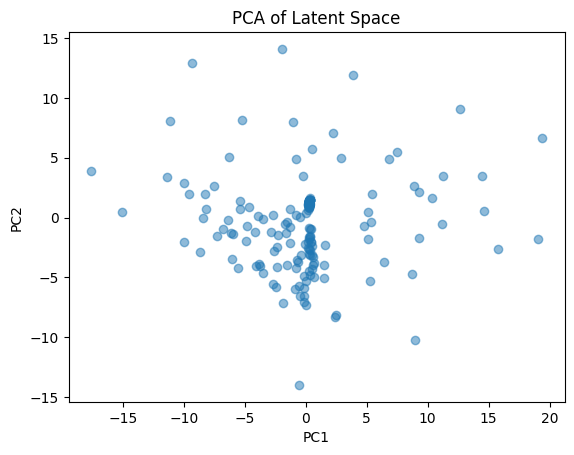

Analyzing latent space for UNet...


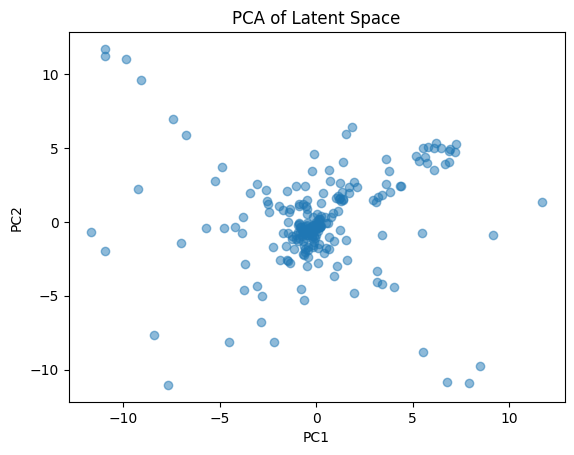

Analyzing latent space for DeconvUNet...


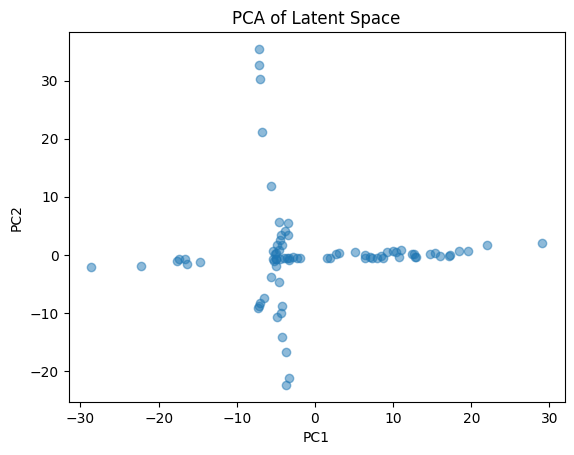

Analyzing latent space for DeconvUNet...


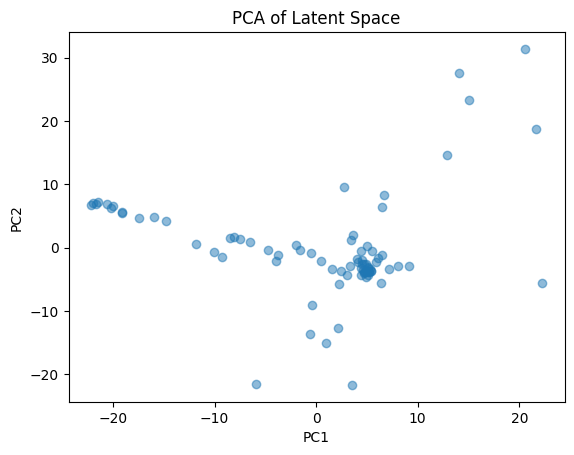

In [9]:
# Analyze latent space
print("Analyzing latent space for UNet...")
analyze_latent_space(unet_model_stripes, striped_dataloader)

print("Analyzing latent space for UNet...")
analyze_latent_space(unet_model_checkerboard, checkerboard_dataloader)

print("Analyzing latent space for DeconvUNet...")
analyze_latent_space(deconv_model_stripes, striped_dataloader)

print("Analyzing latent space for DeconvUNet...")
analyze_latent_space(deconv_model_checkerboard, checkerboard_dataloader)

Visualizing original and reconstructed patterns...


<Figure size 640x480 with 0 Axes>

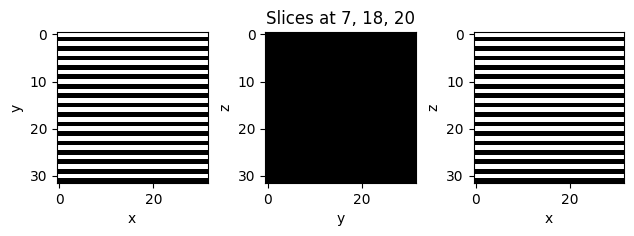

<Figure size 640x480 with 0 Axes>

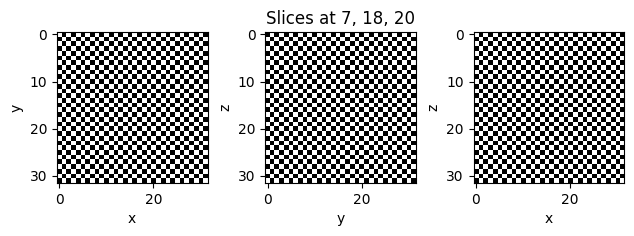

<Figure size 640x480 with 0 Axes>

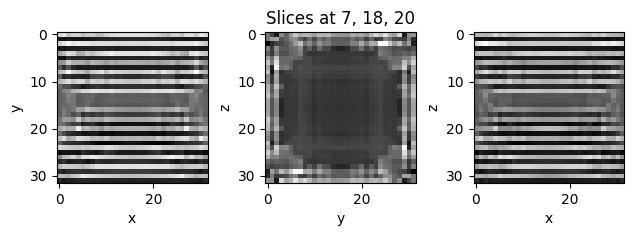

<Figure size 640x480 with 0 Axes>

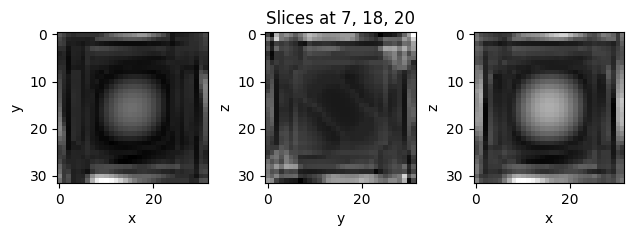

<Figure size 640x480 with 0 Axes>

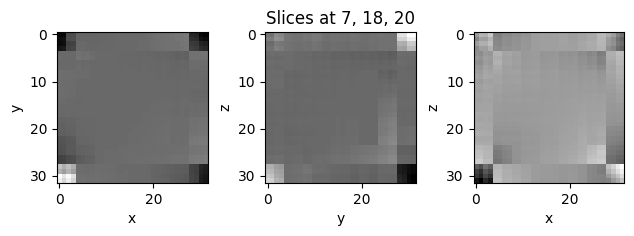

<Figure size 640x480 with 0 Axes>

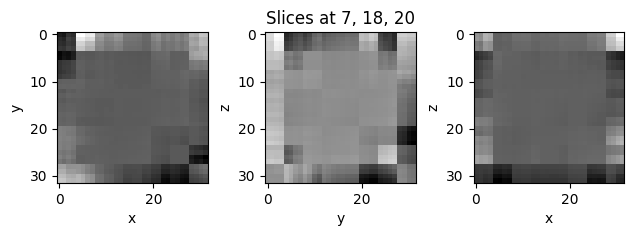

In [11]:
# Visualize reconstruction
x, y, z = 7, 18, 20
print("Visualizing original and reconstructed patterns...")
# Unet model on striped and checkered datasets
viewer(striped_dataset[0, 0].cpu().numpy(), x, y, z)
viewer(checkerboard_dataset[0, 0].cpu().numpy(), x, y, z)
viewer(unet_model_stripes(striped_dataset[0:1]).cpu().detach().numpy()[0, 0], x, y, z)
viewer(unet_model_checkerboard(checkerboard_dataset[0:1]).cpu().detach().numpy()[0, 0], x, y, z)

# Deconv model on striped and checkered datasets
viewer(deconv_model_stripes(striped_dataset[0:1]).cpu().detach().numpy()[0, 0], x, y, z)
viewer(deconv_model_checkerboard(checkerboard_dataset[0:1]).cpu().detach().numpy()[0, 0], x, y, z)